In [1]:
############################################################################
##
## Copyright (C) 2021 NVIDIA Corporation.  All rights reserved.
##
## NVIDIA Sample Code
##
## Please refer to the NVIDIA end user license agreement (EULA) associated
## with this source code for terms and conditions that govern your use of
## this software. Any use, reproduction, disclosure, or distribution of
## this software and related documentation outside the terms of the EULA
## is strictly prohibited.
##
############################################################################

In [2]:
import gc
from typing import Union
import os
import time

import cugraph as cg
import cudf
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cuml.metrics import precision_recall_curve, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import auc, roc_curve, classification_report
from cupy import argmax, argmin
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm
print(torch.__version__)
assert int(torch.__version__.split('+')[1][2:]) > 102, 'Use a higher CUDA enabled torch version, ex. CUDA 11.1 or greater'

pd.set_option('display.max_columns', 500)

clean_data_path = '/rapids/notebooks/host/cleaned_data'
figures_path = '/rapids/notebooks/host/figures'
os.makedirs(figures_path, exist_ok=True)

DEVICE = 0
cp.cuda.Device(DEVICE).use()

1.9.0+cu111


# Prep 

In [3]:
# this is the cleaned up data.
datafp = './data/credit_card/card_transaction_fixed.pq'
gdf = cudf.read_parquet(datafp)

gdf['zip'] = gdf.zip.astype(int).astype(str)
gdf['use chip'] = gdf['use chip'].str.strip()
gdf['merchant city'] = gdf['merchant city'].str.strip()

In [4]:
gdf.errors.value_counts()

Insufficient Balance,                                   242783
Bad PIN,                                                 58918
Technical Glitch,                                        48157
Bad Card Number,                                         13321
Bad CVV,                                                 10740
Bad Expiration,                                          10716
Bad Zipcode,                                              2079
Bad PIN,Insufficient Balance,                              581
Insufficient Balance,Technical Glitch,                     457
Bad PIN,Technical Glitch,                                  128
Bad Card Number,Insufficient Balance,                      122
Bad CVV,Insufficient Balance,                               89
Bad Expiration,Insufficient Balance,                        78
Bad Card Number,Bad CVV,                                    60
Bad Card Number,Bad Expiration,                             54
Bad Expiration,Bad CVV,                                

In [5]:
def open_sublist(array: list):
    """
    recursively opens up sublists
    """
    l = []
    for item in array:
        if isinstance(item, list):
            subl = open_sublist(item)
            l.extend(subl)
            continue
        l.append(item)
    return l
# open_sublist([1,[[[2]]],3,[4,5,[6]]])

In [6]:
unq_errors = [i for i in 
                 set( 
                    open_sublist(
                        [i.split(',') for i in gdf.errors.value_counts().index.to_arrow().to_pylist()
                        ])
                 ) if i]
unq_errors

['Technical Glitch',
 'Bad Zipcode',
 'Bad CVV',
 'Bad PIN',
 'Bad Card Number',
 'Bad Expiration',
 'Insufficient Balance']

In [7]:
exploded = gdf['errors'].str.strip(',').str.split(',').explode()

raw_one_hot = cudf.get_dummies(exploded, columns=["errors"])
errs = raw_one_hot.groupby(raw_one_hot.index).sum()

gdf = cudf.concat([gdf, errs], axis=1)

gdf = gdf.rename(columns={col:f'errors_{col}' for col in unq_errors})

# add day of the week feature
gdf['dayofweek'] = cudf.to_datetime(gdf.date).dt.dayofweek

In [8]:
# we'll make the (bad) assumption that the users have all their credit cards at the very beginning of the
# simulation

num_cards_per_user = gdf[['user', 'card']].groupby('user').card.nunique()

num_cards_per_user = num_cards_per_user.rename('num_cards_per_user')

gdf = cudf.merge(gdf, num_cards_per_user, on='user', how='left')

del exploded, errs, raw_one_hot, num_cards_per_user
gc.collect()

22

In [9]:
# looks like we have some nans... let's remove them
gdf.isna().sum()

user                                  0
card                                  0
date                                  0
year                                  0
month                                 0
day                                   0
time                                  0
hour                                  0
minute                                0
amount                                0
use chip                              0
merchant name                         0
merchant city                         0
merchant state                  2720821
zip                             2878135
mcc                                   0
errors                         23998469
is_fraud                              0
errors_Bad CVV                        0
errors_Bad Card Number                0
errors_Bad Expiration                 0
errors_Bad PIN                        0
errors_Bad Zipcode                    0
errors_Insufficient Balance           0
errors_Technical Glitch               0


In [10]:
gdf['use chip'], unq_use_chip = gdf['use chip'].factorize()

# ERRORS SHOULD BE SPLIT BY COMMA
# dont use: gdf['errors'], unq_errors = gdf['errors'].factorize()

# frequency and agg stats...
grp_stats = gdf.groupby('card')['amount'].agg(['mean', 'std']).rename(columns={'mean': 'mean_card_amount', 
                                                                               'std': 'std_card_amount'})

gdf['mean_card_amount'] = gdf['card'].map(grp_stats.to_pandas().to_dict()['mean_card_amount'])
gdf['std_card_amount'] = gdf['card'].map(grp_stats.to_pandas().to_dict()['std_card_amount'])
gdf['card_counts'] = gdf['card'].map(gdf.card.value_counts().to_pandas().to_dict())

# remove nans in strings
gdf['zip'] = gdf.zip.astype(str)

# fill nans with empty string...
gdf['zip'] = gdf['zip'].fillna('')
gdf['merchant state'] = gdf['merchant state'].fillna('')


# yippy kai yay!
# gdf.isna().sum()

# aggregation
gdf['merchant_city_state_zip'] = gdf['merchant city'] + ' ' +\
                                 gdf['merchant state'] + ' ' +\
                                 gdf['zip']

# remove any extra trailing whitespace
gdf['merchant_city_state_zip'] = gdf['merchant_city_state_zip'].str.strip()
# factorize merchant names since min/max of their names (which is an int) is at the bounds of 64 bit int
gdf['merchant name'], merch_name_uniq = gdf['merchant name'].factorize()
gdf['merchant_city_state_zip'], merch_city_state_zip_uniq = gdf['merchant_city_state_zip'].factorize()
gdf['merchant city'], merc_city_uniq = gdf['merchant city'].factorize()
gdf['merchant state'], merc_state_uniq = gdf['merchant state'].factorize()
gdf['zip'], zip_uniq = gdf['zip'].factorize()

# range from 0 to 29 inclusive
# for inference, will need to add back 1991 years.
min_year = gdf.year.min()
gdf['year'] = gdf.year-gdf.year.min()

In [11]:
# encode all real mccs
import iso18245
all_mccs_info = iso18245.get_all_mccs()
all_mccs = sorted([int(mcc.mcc) for mcc in all_mccs_info])


gdf['mcc'] = gdf['mcc'].map({all_mccs[i]: i for i in range(len(all_mccs))})

In [12]:
hrs_since_last_txn = gdf[['user', 'date']].to_pandas().groupby('user').diff().astype('timedelta64[s]')/3600

hrs_since_last_txn = hrs_since_last_txn.rename(columns={'date': 'hrs_since_last_txn'})

gdf['hrs_since_last_txn'] = cudf.concat([gdf, cudf.from_pandas(hrs_since_last_txn)], axis=1)[['user', 'hrs_since_last_txn']]\
                                .to_pandas().groupby('user').transform(lambda x: x.fillna(x.mean()))['hrs_since_last_txn']

In [13]:
mappings = {'unq_use_chip': unq_use_chip,
            'merch_name_uniq': merch_name_uniq,
            'merch_city_state_zip_uniq': merch_city_state_zip_uniq,
            'merc_city_uniq': merc_city_uniq,
            'merc_state_uniq': merc_state_uniq,
            'zip_uniq': zip_uniq,
            'all_mccs': all_mccs,
           }

In [14]:
import pickle
with open(f'./data/mappings.pkl', 'wb') as f:
    pickle.dump(mappings, f)

In [15]:
num_cols = sorted(['amount', 'hrs_since_last_txn',
#                 'mean_card_amount', 'std_card_amount', 'card_counts',
            ])
cat_cols = sorted(['card', 'num_cards_per_user', 'year', 'month', 'day', 'hour', 'minute', 'use chip', 'merchant name', 'merchant city',
            'merchant state', 'zip', 'mcc', 'merchant_city_state_zip', 
            'errors_Bad CVV', 'errors_Bad Card Number', 'errors_Bad Expiration', 'errors_Bad PIN',
            'errors_Bad Zipcode', 'errors_Insufficient Balance', 'errors_Technical Glitch'
           ])
feature_cols = num_cols + cat_cols
target_col = ['is_fraud']

In [16]:
# train-test-split 
# take last few percent of data for test
test_size = int(gdf.shape[0]*0.05)
traindf = gdf[feature_cols + target_col].iloc[:-test_size]
testdf = gdf[feature_cols + target_col].iloc[-test_size:]

In [17]:
from cuml.preprocessing import StandardScaler

amt_scaler = StandardScaler()
hrs_last_txn_scaler = StandardScaler()

traindf['amount'] = amt_scaler.fit_transform(traindf[['amount']])
testdf['amount'] = amt_scaler.transform(testdf[['amount']])

traindf['hrs_since_last_txn'] = hrs_last_txn_scaler.fit_transform(traindf[['hrs_since_last_txn']])
testdf['hrs_since_last_txn'] = hrs_last_txn_scaler.transform(testdf[['hrs_since_last_txn']])


In [18]:
traindf.to_parquet(f'./data/credit_card/lstm_train.parquet')
testdf.to_parquet(f'./data/credit_card/lstm_test.parquet')
gdf.to_parquet(f'./data/credit_card/lstm_gdf.parquet')

# Read Data

In case the kernel is restarted, you can import the libraries at the top and continue from here.

In [19]:
traindf = cudf.read_parquet(f'./data/credit_card/lstm_train.parquet')
testdf = cudf.read_parquet(f'./data/credit_card/lstm_test.parquet')
gdf = cudf.read_parquet(f'./data/credit_card/lstm_gdf.parquet')



In [20]:
CONTINUOUS_COLUMNS = sorted(['amount', 'hrs_since_last_txn',
#                 'mean_card_amount', 'std_card_amount', 'card_counts',
            ])
CATEGORICAL_COLUMNS = sorted(['card', 'num_cards_per_user', 'year', 'month', 'day', 'hour', 'minute', 'use chip', 'merchant name', 'merchant city',
            'merchant state', 'zip', 'mcc', 'merchant_city_state_zip', 
            'errors_Bad CVV', 'errors_Bad Card Number', 'errors_Bad Expiration', 'errors_Bad PIN',
            'errors_Bad Zipcode', 'errors_Insufficient Balance', 'errors_Technical Glitch'
           ])
feature_cols = CONTINUOUS_COLUMNS + CATEGORICAL_COLUMNS
LABEL_COLUMNS = ['is_fraud']

BATCH_SIZE=512
EPOCHS = 20
LEARNING_RATE = 1e-5

# change continuous and categorical cols to be same respective type for nvtabular.
traindf[CATEGORICAL_COLUMNS] = traindf[CATEGORICAL_COLUMNS].astype(cp.int32)
traindf[CONTINUOUS_COLUMNS]= traindf[CONTINUOUS_COLUMNS].astype(cp.float32)
testdf[CATEGORICAL_COLUMNS] = testdf[CATEGORICAL_COLUMNS].astype(cp.int32)
testdf[CONTINUOUS_COLUMNS]= testdf[CONTINUOUS_COLUMNS].astype(cp.float32)

In [21]:
import pickle
with open(f'./data/mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)

# calculate cardinality of categorical features
cards = [max(gdf[col].nunique(), gdf[col].max() + 1) for col in CATEGORICAL_COLUMNS]
for cat, card in zip(CATEGORICAL_COLUMNS, cards):
    print(f'{cat}: {card}')

card: 9
day: 32
errors_Bad CVV: 2
errors_Bad Card Number: 2
errors_Bad Expiration: 2
errors_Bad PIN: 2
errors_Bad Zipcode: 2
errors_Insufficient Balance: 2
errors_Technical Glitch: 2
hour: 24
mcc: 892
merchant city: 13429
merchant name: 100343
merchant state: 224
merchant_city_state_zip: 27514
minute: 60
month: 13
num_cards_per_user: 10
use chip: 3
year: 30
zip: 27322


In [22]:
import nvtabular as nvt
from nvtabular.loader.torch import TorchAsyncItr, DLDataLoader

In [23]:
train_dataset = TorchAsyncItr(
    nvt.Dataset(traindf),
    cats=CATEGORICAL_COLUMNS,
    conts=CONTINUOUS_COLUMNS,
    labels=LABEL_COLUMNS,
    batch_size=BATCH_SIZE,
    device=DEVICE
)

train_loader = DLDataLoader(
    train_dataset,
    batch_size=None,
    pin_memory=False,
    num_workers=0
)

test_dataset = TorchAsyncItr(
    nvt.Dataset(testdf),
    cats=CATEGORICAL_COLUMNS,
    conts=CONTINUOUS_COLUMNS,
    labels=LABEL_COLUMNS,
    batch_size=BATCH_SIZE,
    device=DEVICE
)

test_loader = DLDataLoader(
    train_dataset,
    batch_size=None,
    pin_memory=False,
    num_workers=0
)

# Utilities

In [24]:
def save_checkpoint(model, optimizer, epoch: int, best_score, file_name, threshold, save_path: str, k_fold=0):
    """
    Save checkpoint to pytorch .pt file.
    Args:
        model: Instance of Pytorch model.
        optimizer: pytorch optimizer ex. torch.optim.Adam() instance
        epoch: epoch number
        best_score: model best score acccoring to appropriate metric.
                    Can be multiple, just save as a dict. of {'metric': score}
        k_fold: int or string for K-folds.
        file_name (str): filename usually including the name of the model.:

    Returns:

    """
    checkpoint = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'k_fold': k_fold,
        'epoch': epoch,
        'best_score': best_score,
        'threshold': threshold
    }
    if not save_path:
        save_path = '.'
    os.makedirs(f'{save_path}/checkpoints/', exist_ok=True)

    torch.save(checkpoint, f'{save_path}/checkpoints/{file_name}.pt')


def load_checkpoint(file_name: str, model, device: str, save_path: str):
    """
    Load Checkpoint from pytorch .pt file.

    Args:
        device: str
        file_name (str): filename usually including the name of the model.
        model_cls: (uninstantiated) class belonging to a custom nn.Module
        **kwargs:

    Returns:

    """
    # instantiate the model and pass in input params as kwargs.
    model = model.to(device)
    if not save_path:
        save_path = '.'
    checkpoint = torch.load(f'{save_path}/checkpoints/{file_name}.pt')
    model.load_state_dict(checkpoint['model'])
    model.eval()
    return model, checkpoint['threshold']

def cupy2numpy(obj, use_cpu):
    if use_cpu and isinstance(obj, cp._core.core.ndarray):
        return obj.get()
    elif use_cpu and isinstance(obj, cudf.core.series.Series):
        return obj.to_array()
    return obj

In [25]:
def train_epoch(model, loader, optimizer, loss_func, metric, device, epoch=''):
    model.train()
    model.zero_grad()
    train_loss = torch.zeros(len(loader), requires_grad=False, device=device)
    train_metric = torch.zeros(len(loader), requires_grad=False, device=device)
    batch = 0
    pbar = tqdm(loader)
    
    train_logits = []
    train_targets = []
    
    for x_cat, x_cont, target in pbar:
        # make prediction
        logits = model(x_cat, x_cont).squeeze()
        
        # calculate loss
        loss = loss_func(logits, target)  # criterion
        loss.backward()
        optimizer.step()
        for param in model.parameters():
            param.grad = None
        
        train_loss[batch] = loss.detach()
        train_metric[batch] = metric(logits, target)
        
        train_targets.append(target.detach())
        train_logits.append(logits.detach())
        
        batch += 1
        if batch == len(loader) or not batch %100:
            pbar.set_description(f'Epoch: {epoch} mean loss {train_loss[:batch].mean().cpu(): 0.5f}, ' 
                                 f'mean acc: {train_metric[:batch].mean().cpu(): 0.5f}')
        
    return train_loss, train_logits, train_targets

def val_epoch(model, loader, loss_func, device):
    model.eval()
    val_logits = []
    val_targets = []
    val_loss = torch.zeros(len(loader), requires_grad=False, device=device)
    
    with torch.no_grad():
        batch=0
        for x_cat, x_cont, target in tqdm(iter(loader)):
            # make prediction
            logits = model(x_cat, x_cont).squeeze()
            
            # calculate loss
            loss = loss_func(logits, target)  # criterion
            
            # save some data
            val_targets.append(target.detach())
            val_logits.append(logits.detach())
            val_loss[batch] = loss.detach()
            batch+=1
        val_loss = val_loss.mean()
    return val_loss, val_logits, val_targets


def calc_metrics(model, _targets, _logits, tst_loader, loss_func, device, use_cpu):
    # scoring on train
    if not use_cpu:
        _targets = cp.asarray(torch.cat(_targets)).astype(int)
        _probs = cp.asarray(torch.sigmoid(torch.cat(_logits)))
    else:
        _targets = np.array(torch.cat(_targets)).astype(int)
        _probs = np.array(torch.sigmoid(torch.cat(_logits)))

    # # calc precision, recall and find threshold for maximum F1 score on train.
    precision, recall, thresholds = precision_recall_curve(_targets, _probs)
    
    threshold_idx = argmax((2 * precision * recall) / (precision + recall))
    threshold = thresholds[threshold_idx]

    # now on test set
    _, _logits, _targets = val_epoch(model, tst_loader, loss_func, device)
    if not use_cpu:
        _targets = cp.asarray(torch.cat(_targets)).astype(int)
        _probs = cp.asarray(torch.sigmoid(torch.cat(_logits)))
    else:
        _targets = np.array(torch.cat(_targets)).astype(int)
        _probs = np.array(torch.sigmoid(torch.cat(_logits)))
    
    precision, recall, thresholds = precision_recall_curve(_targets, _probs)
    # find threshold index closest to threshold value on train set.
    
    if not use_cpu:
        threshold_idx = cp.argmin(cp.abs(thresholds - threshold))
    else:
        threshold_idx = np.argmin(np.abs(thresholds - threshold))
    
    pred_labels = (_probs >= threshold).astype(int)

    auc_sc = roc_auc_score(_targets, _probs)
    acc_sc = accuracy_score(_targets, pred_labels)
    f1_sc = (2 * precision[threshold_idx] * recall[threshold_idx]) / (precision[threshold_idx] + recall[threshold_idx])
    conf_mat = confusion_matrix(_targets, pred_labels)
    print(f'F1: {f1_sc.item(): 0.4f} '
          f'AUC: {auc_sc: 0.4f} '
          f'Pr: {precision[threshold_idx].item(): 0.4f} '
          f'Rec: {recall[threshold_idx].item(): 0.4f} ', 
          f'Acc: {acc_sc: 0.4f} '
          f'Thresh: {threshold.item(): 0.4f} '
          f'Pred Def: {pred_labels.sum().item()} '
          f'Actual: {int(_targets.sum())} '
          )
    print('Confusion Matrix: \n:', conf_mat)
    return f1_sc.item(), threshold.item()
    
    
def test_em(model, loader, loss_func, threshold, device, use_cpu, save_path: str = None):
    sns.set()
    test_loss, test_logits, test_targets = val_epoch(model, loader, loss_func, device)
    
    # scoring
    if not use_cpu:
        test_targets = cp.asarray(torch.cat(test_targets)).astype(int)
        test_probs = cp.asarray(torch.sigmoid(torch.cat(test_logits)))
    else:
        test_targets = torch.cat(test_targets).numpy().astype(int)
        test_probs = torch.sigmoid(torch.cat(test_logits)).numpy()
    pred_labels = (test_probs >= threshold).astype(int)

    precision, recall, thresholds = precision_recall_curve(test_targets, test_probs)
    
    if not use_cpu:
        threshold_idx = cp.argmin(cp.abs(thresholds - threshold))
    else:
        threshold_idx = np.argmin(np.abs(thresholds - threshold))
    
    auc_sc = roc_auc_score(test_targets, test_probs)
    acc_sc = accuracy_score(test_targets, pred_labels)
    f1_sc = (2 * precision[threshold_idx] * recall[threshold_idx]) / (precision[threshold_idx] + recall[threshold_idx])
    conf_mat = confusion_matrix(test_targets, pred_labels)
    
    auprc= auc(cupy2numpy(recall, not use_cpu), cupy2numpy(precision, not use_cpu))

    print(f'Thresh: {threshold: 0.4f}', f'Prec: {precision[threshold_idx].item(): 0.4f}',
          f'Rec: {recall[threshold_idx].item(): 0.4f}', f'Pred Def: {pred_labels.sum()}',
          f'Actual: {int(test_targets.sum())}', f'AUC: {auc_sc: 0.4f}',
          f'Acc: {acc_sc: 0.4f}',
          f'F1: {f1_sc.item(): 0.4f}',
          f'AUPRC: {auprc: 0.4f}',
         )
    print('Confusion Matrix: \n:', conf_mat)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    no_skill = cupy2numpy(test_targets.mean(), not use_cpu) 
    ax[0].plot(cupy2numpy(recall, not use_cpu), cupy2numpy(precision, not use_cpu), color='darkorange', lw=1, label='PR curve (area = %0.2f)' % auprc)
    ax[0].plot([0,1], [no_skill, no_skill], color='navy', linestyle='--', label='No Skill')
    ax[0].plot(cupy2numpy(recall[threshold_idx], not use_cpu), cupy2numpy(precision[threshold_idx], not use_cpu), 'ro', label='F1 threshold')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_xlim([-0.02, 1.02])
    ax[0].set_ylim([-0.02, 1.02])
    ax[0].set_title('Precision-Recall curve')
    ax[0].legend()
    
    fpr, tpr, threshold = roc_curve(cupy2numpy(test_targets, not use_cpu), cupy2numpy(test_probs, not use_cpu))
    roc_auc = auc(fpr, tpr)

    ax[1].set_title('Receiver Operating Characteristic')
    ax[1].plot(fpr, tpr, 'b', label = 'ROC curve (area = %0.2f)' % roc_auc)
    ax[1].legend(loc = 'lower right')
    ax[1].plot([0, 1], [0, 1],'r--')
    ax[1].set_xlim([-0.02, 1.02])
    ax[1].set_ylim([-0.02, 1.02])
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')   
    
    plt.tight_layout()
    if save_path and isinstance(save_path, str):
        plt.savefig(save_path, dpi=600)
    print("Classification Report for Pytorch Classifier: \n",
          classification_report(cupy2numpy(test_targets, not use_cpu), cupy2numpy(pred_labels, not use_cpu)))
    return test_targets, pred_labels

# Model

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [27]:
class TabLSTM(nn.Module):
    def __init__(self, cat_cards, numer_dims, hidden_size=128):
        """
        cat_cards (list): list of integers, where each integer is the cardinality of the SORTED column names
        numer_dims (int): number of numerical dimensions
        """
        super(TabLSTM, self).__init__()
        
        self.num_cats = len(cat_cards)
        self.hidden_size = hidden_size
        self.embeddings = nn.ModuleList([nn.Embedding(cat_card, min(50, cat_card//2 + 1)) for
                                        cat_card in cat_cards])
        
        total_embed_dims = sum(i.embedding_dim for i in self.embeddings)
        input_size = total_embed_dims + numer_dims
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
#         nn.init.orthogonal_(self.lstm.weight_ih_l0)
#         nn.init.orthogonal_(self.lstm.weight_hh_l0)
#         nn.init.zeros_(self.lstm.bias_ih_l0)
#         nn.init.ones_(self.lstm.bias_ih_10[hidden_size: hidden_size*2])
#         nn.init.zeros_(self.lstm.bias_hh_l0)
#         nn.init.ones_(self.lstm.bias_hh_10[hidden_size: hidden_size*2])
    def forward(self, cat_inputs, numer_inputs):
        
        inputs = torch.cat([self.embeddings[col](cat_inputs[:, col]) 
                            for col in range(self.num_cats)] + [numer_inputs], dim=1)
        batch, d = inputs.shape
        
        x, _ = self.lstm(inputs.reshape(batch, 1, d))
#         print('xshape', x.shape, x.reshape(512, 128).shape)
        x = self.linear(x.reshape(batch, self.hidden_size))
#         print('xsize', x.shape)
        return x

In [28]:
device = torch.device(f"cuda:{DEVICE}" if torch.cuda.is_available() else "cpu")
# device='cpu'
print(device)

model = TabLSTM(cat_cards=cards, numer_dims=len(CONTINUOUS_COLUMNS)).to(device)

print(model)
criterion = nn.BCEWithLogitsLoss() # pos_weight=torch.tensor(25, device=device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

cuda:0
TabLSTM(
  (embeddings): ModuleList(
    (0): Embedding(9, 5)
    (1): Embedding(32, 17)
    (2): Embedding(2, 2)
    (3): Embedding(2, 2)
    (4): Embedding(2, 2)
    (5): Embedding(2, 2)
    (6): Embedding(2, 2)
    (7): Embedding(2, 2)
    (8): Embedding(2, 2)
    (9): Embedding(24, 13)
    (10): Embedding(892, 50)
    (11): Embedding(13429, 50)
    (12): Embedding(100343, 50)
    (13): Embedding(224, 50)
    (14): Embedding(27514, 50)
    (15): Embedding(60, 31)
    (16): Embedding(13, 7)
    (17): Embedding(10, 6)
    (18): Embedding(3, 2)
    (19): Embedding(30, 16)
    (20): Embedding(27322, 50)
  )
  (lstm): LSTM(413, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


# Training and Results

In [29]:

def binary_acc(y_pred, y_test):
    with torch.no_grad():
        y_pred_tag = torch.round(torch.sigmoid(y_pred))
        correct_results_sum = (y_pred_tag == y_test).sum().float()
        acc = correct_results_sum/y_test.shape[0]
    return acc
    

model_name = 'fnma_model_lstm_nvt'
use_cpu= False

start = time.time()
max_f1 = 0
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    train_loss, train_logits, train_targets = train_epoch(model, train_loader, optimizer, criterion, metric=binary_acc, device=device,
                             epoch=e)
    epoch_f1_score, threshold = calc_metrics(model, train_targets, train_logits, test_loader, criterion, device, use_cpu)
    if epoch_f1_score > max_f1:
        max_f1 = epoch_f1_score
        # save the model
        save_checkpoint(model, optimizer, e, epoch_f1_score, model_name, threshold=threshold, save_path=clean_data_path)
    
print(f'Total time: {time.time() - start}')


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.2211 AUC:  0.9507 Pr:  0.5563 Rec:  0.1380  Acc:  0.9988 Thresh:  0.5455 Pred Def: 7170 Actual: 28913 
Confusion Matrix: 
: [[23135461     3181]
 [   24924     3989]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.5848 AUC:  0.9689 Pr:  0.7785 Rec:  0.4683  Acc:  0.9992 Thresh:  0.2859 Pred Def: 17392 Actual: 28913 
Confusion Matrix: 
: [[23134789     3853]
 [   15374    13539]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.6869 AUC:  0.9778 Pr:  0.8222 Rec:  0.5898  Acc:  0.9993 Thresh:  0.3640 Pred Def: 20742 Actual: 28913 
Confusion Matrix: 
: [[23134953     3689]
 [   11860    17053]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.7347 AUC:  0.9826 Pr:  0.8365 Rec:  0.6549  Acc:  0.9994 Thresh:  0.3355 Pred Def: 22638 Actual: 28913 
Confusion Matrix: 
: [[23134940     3702]
 [    9977    18936]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.7497 AUC:  0.9855 Pr:  0.8499 Rec:  0.6707  Acc:  0.9994 Thresh:  0.3809 Pred Def: 22819 Actual: 28913 
Confusion Matrix: 
: [[23135216     3426]
 [    9520    19393]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.7618 AUC:  0.9875 Pr:  0.8577 Rec:  0.6852  Acc:  0.9995 Thresh:  0.3697 Pred Def: 23098 Actual: 28913 
Confusion Matrix: 
: [[23135356     3286]
 [    9101    19812]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.7691 AUC:  0.9889 Pr:  0.8637 Rec:  0.6931  Acc:  0.9995 Thresh:  0.3614 Pred Def: 23200 Actual: 28913 
Confusion Matrix: 
: [[23135481     3161]
 [    8874    20039]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.7753 AUC:  0.9900 Pr:  0.8710 Rec:  0.6986  Acc:  0.9995 Thresh:  0.3666 Pred Def: 23193 Actual: 28913 
Confusion Matrix: 
: [[23135649     2993]
 [    8713    20200]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.7816 AUC:  0.9908 Pr:  0.8837 Rec:  0.7006  Acc:  0.9995 Thresh:  0.3948 Pred Def: 22920 Actual: 28913 
Confusion Matrix: 
: [[23135978     2664]
 [    8657    20256]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.7866 AUC:  0.9914 Pr:  0.8913 Rec:  0.7039  Acc:  0.9995 Thresh:  0.3983 Pred Def: 22834 Actual: 28913 
Confusion Matrix: 
: [[23136161     2481]
 [    8560    20353]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.7901 AUC:  0.9919 Pr:  0.8936 Rec:  0.7081  Acc:  0.9995 Thresh:  0.3807 Pred Def: 22913 Actual: 28913 
Confusion Matrix: 
: [[23136203     2439]
 [    8439    20474]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.7942 AUC:  0.9924 Pr:  0.9007 Rec:  0.7103  Acc:  0.9995 Thresh:  0.3891 Pred Def: 22798 Actual: 28913 
Confusion Matrix: 
: [[23136380     2262]
 [    8377    20536]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.7967 AUC:  0.9927 Pr:  0.9046 Rec:  0.7118  Acc:  0.9995 Thresh:  0.3948 Pred Def: 22749 Actual: 28913 
Confusion Matrix: 
: [[23136472     2170]
 [    8334    20579]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.7988 AUC:  0.9930 Pr:  0.9070 Rec:  0.7136  Acc:  0.9996 Thresh:  0.3895 Pred Def: 22748 Actual: 28913 
Confusion Matrix: 
: [[23136527     2115]
 [    8280    20633]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.8028 AUC:  0.9933 Pr:  0.9184 Rec:  0.7130  Acc:  0.9996 Thresh:  0.4300 Pred Def: 22446 Actual: 28913 
Confusion Matrix: 
: [[23136811     1831]
 [    8298    20615]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.8045 AUC:  0.9936 Pr:  0.9191 Rec:  0.7152  Acc:  0.9996 Thresh:  0.4218 Pred Def: 22500 Actual: 28913 
Confusion Matrix: 
: [[23136822     1820]
 [    8233    20680]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.8062 AUC:  0.9938 Pr:  0.9191 Rec:  0.7179  Acc:  0.9996 Thresh:  0.4137 Pred Def: 22586 Actual: 28913 
Confusion Matrix: 
: [[23136814     1828]
 [    8155    20758]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.8051 AUC:  0.9940 Pr:  0.9085 Rec:  0.7228  Acc:  0.9996 Thresh:  0.3764 Pred Def: 23004 Actual: 28913 
Confusion Matrix: 
: [[23136536     2106]
 [    8015    20898]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.8104 AUC:  0.9942 Pr:  0.9251 Rec:  0.7210  Acc:  0.9996 Thresh:  0.4260 Pred Def: 22533 Actual: 28913 
Confusion Matrix: 
: [[23136954     1688]
 [    8068    20845]]


  0%|          | 0/45250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

F1:  0.8084 AUC:  0.9944 Pr:  0.9097 Rec:  0.7274  Acc:  0.9996 Thresh:  0.3799 Pred Def: 23116 Actual: 28913 
Confusion Matrix: 
: [[23136556     2086]
 [    7883    21030]]
Total time: 6503.9026000499725


In [30]:
model, threshold = load_checkpoint(model_name, model, device, save_path=clean_data_path)

0it [00:00, ?it/s]

Thresh:  0.4260 Prec:  0.9251 Rec:  0.7210 Pred Def: 22533 Actual: 28913 AUC:  0.9942 Acc:  0.9996 F1:  0.8104 AUPRC:  0.7996
Confusion Matrix: 
: [[23136954     1688]
 [    8068    20845]]
Classification Report for Pytorch Classifier: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00  23138642
           1       0.93      0.72      0.81     28913

    accuracy                           1.00  23167555
   macro avg       0.96      0.86      0.91  23167555
weighted avg       1.00      1.00      1.00  23167555



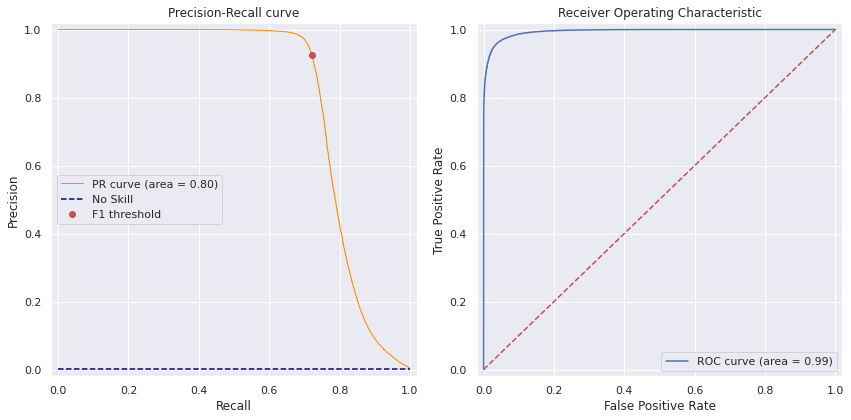

In [31]:
# out of sample performance.
true_labels, pred_labels = test_em(model, test_loader, criterion, threshold, device, use_cpu=use_cpu,
                                   save_path=f'{figures_path}/out_of_sample_nvt_lstm_pr_roc.png')

In [32]:
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', save_path=None, cmap=plt.cm.cool):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    if save_path and isinstance(save_path, str):
        plt.savefig(save_path, dpi=600)

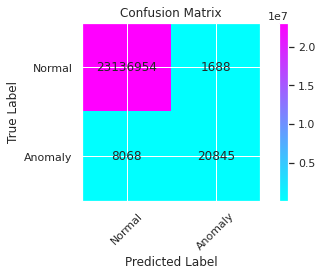

In [33]:
results = confusion_matrix(true_labels, pred_labels)
results = cupy2numpy(results, True)
plot_confusion_matrix(results, ['Normal','Anomaly'], title='Confusion Matrix', save_path=f'{figures_path}/nvt_lstm_confusion_matrix.png')